In [1]:
pip install pyabf numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# visualise the traces

Rising edges detected at [0.3063 6.5063] seconds.


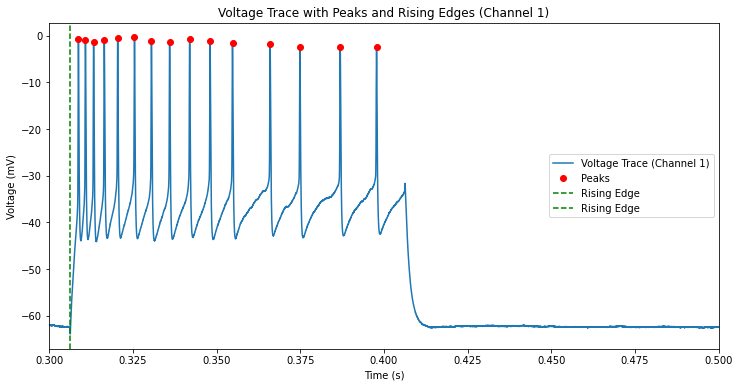

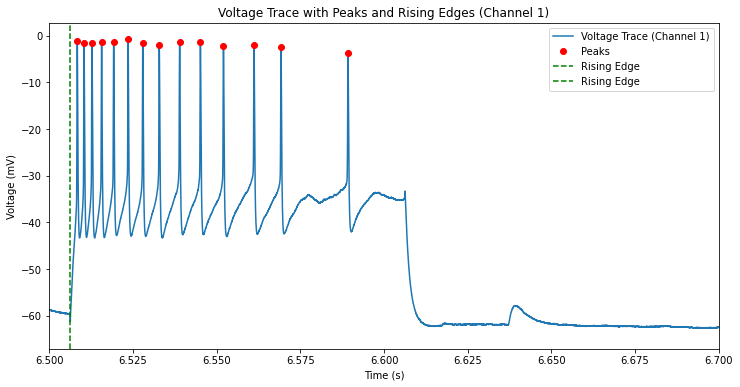

In [33]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the ABF file
file_path = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\light\24530009.abf' # Replace with your file path
abf = pyabf.ABF(file_path)


# Select Channel 2 (index 1 since Python is 0-indexed) for square pulses
channel_index_pulse = 1
abf.setSweep(sweepNumber=0, channel=channel_index_pulse)

# Extract the time and voltage data for Channel 2
time_pulse = abf.sweepX  # Time in seconds
voltage_pulse = abf.sweepY  # Voltage in mV

# Identify the start of the square pulses (rising edges)
rising_edges_indices = np.where(np.diff(voltage_pulse) > 10)[0]  # Adjust threshold if necessary
rising_edges_times = time_pulse[rising_edges_indices]

print(f"Rising edges detected at {rising_edges_times} seconds.")

# Switch to the channel where the action potentials (bursts) are present, usually Channel 1 (index 0)
channel_index_burst = 0
abf.setSweep(sweepNumber=0, channel=channel_index_burst)

# Extract the time and voltage data for the action potential channel
time_burst = abf.sweepX  # Time in seconds
voltage_burst = abf.sweepY  # Voltage in mV

# Find the peaks (action potentials) in the burst channel
peaks, _ = find_peaks(voltage_burst, height=-20)  # Detect peaks above a lower threshold, adjust -30 as needed



# Plot the voltage trace with peaks and rising edges highlighted for the burst channel
plt.figure(figsize=(12, 6))
plt.plot(time_burst, voltage_burst, label='Voltage Trace (Channel 1)')
plt.plot(time_burst[peaks], voltage_burst[peaks], "ro", label='Peaks')
for rising_edge_time in rising_edges_times:
    plt.axvline(x=rising_edge_time, color='g', linestyle='--', label='Rising Edge')
plt.title('Voltage Trace with Peaks and Rising Edges (Channel 1)')
plt.xlim(0.3,0.5)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()

# Plot the voltage trace with peaks and rising edges highlighted for the burst channel
plt.figure(figsize=(12, 6))
plt.plot(time_burst, voltage_burst, label='Voltage Trace (Channel 1)')
plt.plot(time_burst[peaks], voltage_burst[peaks], "ro", label='Peaks')
for rising_edge_time in rising_edges_times:
    plt.axvline(x=rising_edge_time, color='g', linestyle='--', label='Rising Edge')
plt.title('Voltage Trace with Peaks and Rising Edges (Channel 1)')
plt.xlim(6.5,6.7)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()




# compute parameters

In [42]:
import pyabf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import pickle
import re

# Load the ABF file
file_path = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\no_light\24530016.abf' 
abf = pyabf.ABF(file_path)


# Determine condition based on the exact folder name in the file path
if os.path.basename(os.path.dirname(file_path)).lower() == 'light':
    condition = 'light'
elif os.path.basename(os.path.dirname(file_path)).lower() == 'no_light':
    condition = 'no_light'
else:
    condition = 'unknown'

fish_id_match = re.search(r'\d{6}_F\d_C\d', file_path)
fish_id = fish_id_match.group(0) if fish_id_match else 'unknown_fish_id'

output_dir = os.path.join(os.path.dirname(file_path), 'analysis')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

current_threshold = -20  # Input for threshold

file_name = os.path.basename(file_path).replace(".abf", "").strip()  # Ensure no leading/trailing spaces
experiment = "excitability"

# Select Channel 2 (index 1 since Python is 0-indexed) for square pulses
channel_index_pulse = 1
abf.setSweep(sweepNumber=0, channel=channel_index_pulse)

# Extract the time and voltage data for Channel 2
time_pulse = abf.sweepX  # Time in seconds
voltage_pulse = abf.sweepY  # Voltage in mV

# Identify the start of the square pulses (rising edges)
rising_edges_indices = np.where(np.diff(voltage_pulse) > 10)[0]  
rising_edges_times = time_pulse[rising_edges_indices]

# Switch to the channel where the action potentials (bursts) are present, usually Channel 1 (index 0)
channel_index_burst = 0
abf.setSweep(sweepNumber=0, channel=channel_index_burst)

# Extract the time and voltage data for the action potential channel
time_burst = abf.sweepX  # Time in seconds
voltage_burst = abf.sweepY  # Voltage in mV

# Find the peaks (action potentials) in the burst channel using the user-defined threshold
peaks, properties = find_peaks(voltage_burst, height=current_threshold)

data_for_csv = []
all_amplitudes = []
all_isis = []

# Step 1: Spikes between the first and second square pulses
rising_edge_time_1 = rising_edges_times[0]
rising_edge_time_2 = rising_edges_times[1]

time_window_mask_1 = (time_burst > rising_edge_time_1) & (time_burst < rising_edge_time_2)
peaks_in_window_1 = peaks[time_window_mask_1[peaks]]

if len(peaks_in_window_1) > 0:
    num_spikes_1 = len(peaks_in_window_1)
    frequency_1 = num_spikes_1 / (time_burst[peaks_in_window_1[-1]] - time_burst[peaks_in_window_1[0]]) if num_spikes_1 > 1 else 0
    isi_1 = np.median(np.diff(time_burst[peaks_in_window_1])) if num_spikes_1 > 1 else np.nan
    amplitudes_1 = voltage_burst[peaks_in_window_1] - voltage_burst[rising_edges_indices[0]]
    median_amplitude_1 = np.median(amplitudes_1)
    latency_1 = time_burst[peaks_in_window_1[0]] - rising_edge_time_1

    # Append the results to the list for Step 1
    data_for_csv.append([condition, fish_id, experiment, 1, current_threshold, num_spikes_1, frequency_1, isi_1, median_amplitude_1, latency_1])
    all_amplitudes.append(amplitudes_1)
    all_isis.append(np.diff(time_burst[peaks_in_window_1]) if num_spikes_1 > 1 else np.array([np.nan]))

    # Plot zoomed peak detection for Step 1
    plt.figure(figsize=(12, 6))
    plt.plot(time_burst, voltage_burst, label='Voltage Trace (Channel 1)')
    plt.plot(time_burst[peaks_in_window_1], voltage_burst[peaks_in_window_1], "ro", label='Peaks')
    plt.axvline(x=rising_edge_time_1, color='g', linestyle='--', label='Rising Edge 1')
    plt.axvline(x=rising_edge_time_2, color='b', linestyle='--', label='Rising Edge 2')
    plt.xlim(rising_edge_time_1 - 0.01, time_burst[peaks_in_window_1[-1]] + 0.05)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
    plt.title('Zoomed Peak Detection - Step 1')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{file_name}_step_1_zoomed_peaks.png"))
    plt.close()

# Step 2: Spikes after the second square pulse
time_window_mask_2 = time_burst > rising_edge_time_2
peaks_in_window_2 = peaks[time_window_mask_2[peaks]]

if len(peaks_in_window_2) > 0:
    num_spikes_2 = len(peaks_in_window_2)
    frequency_2 = num_spikes_2 / (time_burst[peaks_in_window_2[-1]] - time_burst[peaks_in_window_2[0]]) if num_spikes_2 > 1 else 0
    isi_2 = np.median(np.diff(time_burst[peaks_in_window_2])) if num_spikes_2 > 1 else np.nan
    amplitudes_2 = voltage_burst[peaks_in_window_2] - voltage_burst[rising_edges_indices[1]]
    median_amplitude_2 = np.median(amplitudes_2)
    latency_2 = time_burst[peaks_in_window_2[0]] - rising_edge_time_2

    # Append the results to the list for Step 2
    data_for_csv.append([condition, fish_id, experiment, 2, current_threshold, num_spikes_2, frequency_2, isi_2, median_amplitude_2, latency_2])
    all_amplitudes.append(amplitudes_2)
    all_isis.append(np.diff(time_burst[peaks_in_window_2]) if num_spikes_2 > 1 else np.array([np.nan]))

    # Plot zoomed peak detection for Step 2
    plt.figure(figsize=(12, 6))
    plt.plot(time_burst, voltage_burst, label='Voltage Trace (Channel 1)')
    plt.plot(time_burst[peaks_in_window_2], voltage_burst[peaks_in_window_2], "ro", label='Peaks')
    plt.axvline(x=rising_edge_time_2, color='b', linestyle='--', label='Rising Edge 2')
    plt.xlim(rising_edge_time_2 - 0.01, time_burst[peaks_in_window_2[-1]] + 0.05)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
    plt.title('Zoomed Peak Detection - Step 2')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{file_name}_step_2_zoomed_peaks.png"))
    plt.close()

df = pd.DataFrame(data_for_csv, columns=["Condition", "Fish_ID", "Experiment", "Step", "Threshold", "Num_Spikes", "Frequency", "ISI", "Amplitude", "Latency"])
csv_filename = os.path.join(output_dir, f"{file_name}_excitability_results.csv")
df.to_csv(csv_filename, index=False)

pickle_data = {
    "amplitudes": all_amplitudes,
    "isis": all_isis
}
pickle_filename = os.path.join(output_dir, f"{file_name}_excitability_data.pkl")
with open(pickle_filename, 'wb') as f:
    pickle.dump(pickle_data, f)

print(f"Results saved to {csv_filename} and {pickle_filename}")


Results saved to C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\no_light\analysis\24530016_excitability_results.csv and C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\no_light\analysis\24530016_excitability_data.pkl


# combine csv

In [44]:
import os


# Define the directories containing the CSV files
directories = [
    r'C:\Maha\DATA\patch_clamp\Kevin\excitability\140524_F2_C2\no_light\analysis',
    r'C:\Maha\DATA\patch_clamp\Kevin\excitability\140524_F2_C2\light\analysis'
]

dataframes = []

# Loop through each directory
for directory in directories:
  
    for file_name in os.listdir(directory):
        if file_name.endswith('.csv'):  # Check if the file is a CSV
            file_path = os.path.join(directory, file_name)
         
            df = pd.read_csv(file_path)
            dataframes.append(df)


combined_df = pd.concat(dataframes, ignore_index=True)
output_file = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\combined_analysis.csv'
combined_df.to_csv(output_file, index=False)

print(f"Combined CSV file saved to {output_file}")


Combined CSV file saved to C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\combined_analysis.csv


# plotting

C:\Users\m.dhanasekar\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\m.dhanasekar\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


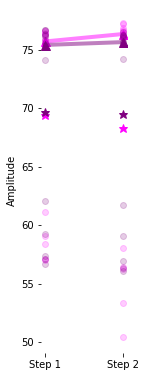

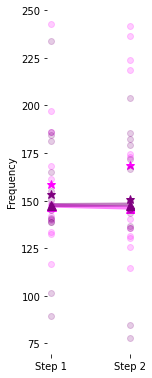

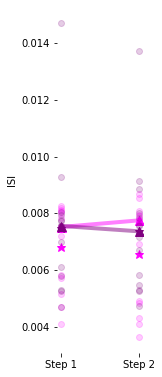

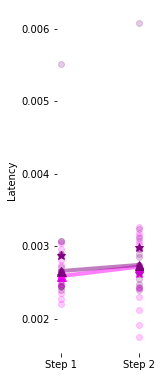

Plots have been generated and saved.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined CSV file
csv_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\combined_stats_plots\excitability_combined.csv'
df = pd.read_csv(csv_file_path)

# Define parameters to plot
parameters = ['Amplitude', 'Frequency', 'ISI', 'Latency']

# Define colors for the conditions
color_mapping = {'light': 'magenta', 'no_light': 'purple'}

# Loop through each parameter and create a plot
for parameter in parameters:
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(2, 6))
    
    # Loop through each condition and plot
    for condition, color in color_mapping.items():
        subset = df[df['Condition'] == condition]
        for _, row in subset.iterrows():
            ax.plot([0.5, 1], [row[parameter] if row['Step'] == 1 else None, row[parameter] if row['Step'] == 2 else None],
                    marker='o', color=color, alpha=0.2)
        
        # Plot the mean and median
        pre_values = subset[subset['Step'] == 1][parameter]
        post_values = subset[subset['Step'] == 2][parameter]
        
        pre_mean = pre_values.mean()
        post_mean = post_values.mean()
        ax.plot([0.5, 1], [pre_mean, post_mean], marker='*', color=color, markersize=9, linestyle='None')
        
        pre_median = pre_values.median()
        post_median = post_values.median()
        ax.plot([0.5, 1], [pre_median, post_median], marker='^', color=color, markersize=9, linestyle='None')
        ax.plot([0.5, 1], [pre_median, post_median], color=color, linewidth=4,alpha=0.5)
    
    # Customize the plot
    ax.set_xticks([0.5, 1])
    ax.set_xticklabels(['Step 1', 'Step 2'])
    #ax.set_xlabel('Step')
    ax.set_ylabel(parameter)
    #ax.set_title(f'Pre and Post {parameter} Scatter Plot')
    
    # Turn off the visibility of the spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Adjust the spacing around the plot
    plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.1)
    
    # Set grid visibility and style
    ax.grid(False)
    
    # Save the plot as SVG and PDF
    svg_path = os.path.join(os.path.dirname(csv_file_path), f'{parameter}_prepost_plot.svg')
    pdf_path = os.path.join(os.path.dirname(csv_file_path), f'{parameter}_prepost_plot.pdf')
    
    fig.savefig(svg_path)
    fig.savefig(pdf_path)
    
    # Show the plot
    plt.show()

print("Plots have been generated and saved.")


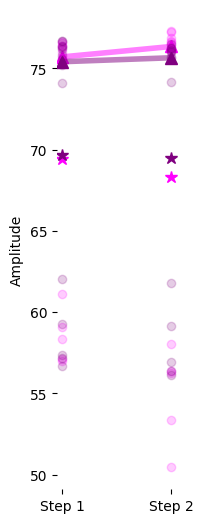

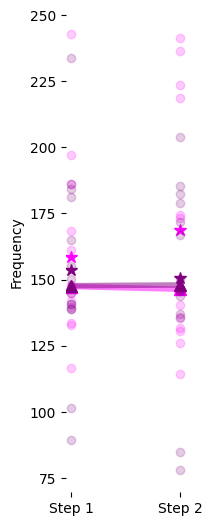

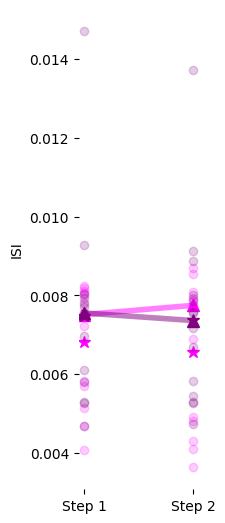

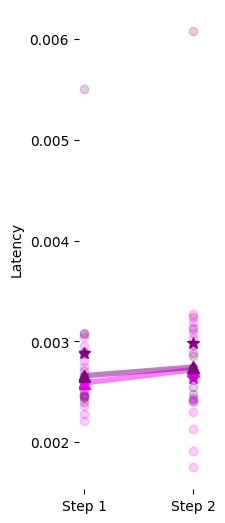

Plots have been generated and saved.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined CSV file
csv_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\combined_stats_plots\excitability_combined.csv'
df = pd.read_csv(csv_file_path)

# Define parameters to plot
parameters = ['Amplitude', 'Frequency', 'ISI', 'Latency']

# Define colors for the conditions
color_mapping = {'light': 'magenta', 'no_light': 'purple'}

# Loop through each parameter and create a plot
for parameter in parameters:
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(2, 6))
    
    # Loop through each condition and plot
    for condition, color in color_mapping.items():
        subset = df[df['Condition'] == condition]
        for _, row in subset.iterrows():
            ax.plot([0.5, 1], [row[parameter] if row['Step'] == 1 else None, row[parameter] if row['Step'] == 2 else None],
                    marker='o', color=color, alpha=0.2)
        
        # Plot the mean and median
        pre_values = subset[subset['Step'] == 1][parameter]
        post_values = subset[subset['Step'] == 2][parameter]
        
        pre_mean = pre_values.mean()
        post_mean = post_values.mean()
        ax.plot([0.5, 1], [pre_mean, post_mean], marker='*', color=color, markersize=9, linestyle='None')
        
        pre_median = pre_values.median()
        post_median = post_values.median()
        ax.plot([0.5, 1], [pre_median, post_median], marker='^', color=color, markersize=9, linestyle='None')
        ax.plot([0.5, 1], [pre_median, post_median], color=color, linewidth=4,alpha=0.5)
    
    # Customize the plot
    ax.set_xticks([0.5, 1])
    ax.set_xticklabels(['Step 1', 'Step 2'])
    #ax.set_xlabel('Step')
    ax.set_ylabel(parameter)
    #ax.set_title(f'Pre and Post {parameter} Scatter Plot')
    
    # Turn off the visibility of the spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Adjust the spacing around the plot
    plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.1)
    
    # Set grid visibility and style
    ax.grid(False)
    
    # Save the plot as SVG and PDF
    svg_path = os.path.join(os.path.dirname(csv_file_path), f'{parameter}_prepost_plot.svg')
    pdf_path = os.path.join(os.path.dirname(csv_file_path), f'{parameter}_prepost_plot.pdf')
    
    fig.savefig(svg_path)
    fig.savefig(pdf_path)
    
    # Show the plot
    plt.show()

print("Plots have been generated and saved.")


In [7]:
for condition, color in color_mapping.items():
    subset = df[df['Condition'] == 'Amplitude']
print(f"\n--- {parameter} | Condition: {condition} ---")
for step in [1, 2]:
    step_data = subset[subset['Step'] == step][parameter].dropna()
    print(f"Step {step} ({len(step_data)} values): {step_data.tolist()}")
    print(f"  Mean:   {step_data.mean()}")
    print(f"  Median: {step_data.median()}")


--- Latency | Condition: no_light ---
Step 1 (0 values): []
  Mean:   nan
  Median: nan
Step 2 (0 values): []
  Mean:   nan
  Median: nan


# mean,median,sem

In [53]:
# Define parameters to calculate statistics for
parameters = ['Amplitude', 'Frequency', 'ISI', 'Latency']

# Initialize a list to hold the summary statistics DataFrame rows
summary_data = []

# Loop through each parameter, condition, and step
for parameter in parameters:
    for condition in ['light', 'no_light']:
        for step in [1, 2]:  # 1 for pre, 2 for post
            subset = df[(df['Condition'] == condition) & (df['Step'] == step)]
            mean_value = subset[parameter].mean()
            median_value = subset[parameter].median()
            sem_value = subset[parameter].sem()  # Standard Error of the Mean
            
            # Append the statistics to the summary data list
            summary_data.append({
                'Parameter': parameter,
                'Condition': condition,
                'Step': 'pre' if step == 1 else 'post',
                'Mean': mean_value,
                'Median': median_value,
                'SEM': sem_value
            })

# Convert the summary data list to a DataFrame
summary_df = pd.DataFrame(summary_data)

# Save the summary DataFrame as a CSV file
summary_csv_path = os.path.join(os.path.dirname(csv_file_path), 'summary_statistics.csv')
summary_df.to_csv(summary_csv_path, index=False)

print(f"Summary statistics saved to {summary_csv_path}")

Summary statistics saved to C:\Maha\DATA\patch_clamp\Kevin\excitability\combined_stats_plots\summary_statistics.csv


# stats comparison

In [54]:
pip install pandas scipy statsmodels matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from scipy.stats import wilcoxon, friedmanchisquare
import os

# Load your data
# Load the combined CSV file
csv_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\combined_stats_plots\excitability_combined.csv'
df = pd.read_csv(csv_file_path)
# Convert 'Step' to pre and post
df['Step'] = df['Step'].replace({1: 'pre', 2: 'post'})

# Define the parameters to be analyzed
parameters = ['Amplitude', 'Frequency', 'ISI', 'Latency']

# Aggregate the data by Fish_ID, Condition, and Step using the mean for the specified parameters
agg_df = df.groupby(['Fish_ID', 'Condition', 'Step'])[parameters].mean().reset_index()

# Save the aggregated data to a new CSV file
agg_csv_path = os.path.join(os.path.dirname(csv_file_path), 'aggregated_data.csv')
agg_df.to_csv(agg_csv_path, index=False)

# Initialize a list to store comparison results
comparison_summary = []

# Loop through each parameter to perform comparisons
for parameter in parameters:
    print(f"\n--- Comparison Results for {parameter} ---")
    
    # Extract data for comparisons
    pre_light = agg_df[(agg_df['Step'] == 'pre') & (agg_df['Condition'] == 'light')][parameter]
    post_light = agg_df[(agg_df['Step'] == 'post') & (agg_df['Condition'] == 'light')][parameter]
    pre_no_light = agg_df[(agg_df['Step'] == 'pre') & (agg_df['Condition'] == 'no_light')][parameter]
    post_no_light = agg_df[(agg_df['Step'] == 'post') & (agg_df['Condition'] == 'no_light')][parameter]

    # Perform Wilcoxon signed-rank tests
    if len(pre_light) > 0 and len(pre_no_light) > 0:
        stat, p_value = wilcoxon(pre_light, pre_no_light)
        print(f"Wilcoxon Test (Pre Light vs. Pre No Light) - Stat: {stat}, p-value: {p_value}")
        comparison_summary.append({
            'Parameter': parameter,
            'Comparison': 'Pre Light vs. Pre No Light',
            'Statistic': stat,
            'p-value': p_value
        })

    if len(post_light) > 0 and len(post_no_light) > 0:
        stat, p_value = wilcoxon(post_light, post_no_light)
        print(f"Wilcoxon Test (Post Light vs. Post No Light) - Stat: {stat}, p-value: {p_value}")
        comparison_summary.append({
            'Parameter': parameter,
            'Comparison': 'Post Light vs. Post No Light',
            'Statistic': stat,
            'p-value': p_value
        })

    if len(pre_light) > 0 and len(post_light) > 0:
        stat, p_value = wilcoxon(pre_light, post_light)
        print(f"Wilcoxon Test (Pre vs. Post Light) - Stat: {stat}, p-value: {p_value}")
        comparison_summary.append({
            'Parameter': parameter,
            'Comparison': 'Pre vs. Post Light',
            'Statistic': stat,
            'p-value': p_value
        })

    if len(pre_no_light) > 0 and len(post_no_light) > 0:
        stat, p_value = wilcoxon(pre_no_light, post_no_light)
        print(f"Wilcoxon Test (Pre vs. Post No Light) - Stat: {stat}, p-value: {p_value}")
        comparison_summary.append({
            'Parameter': parameter,
            'Comparison': 'Pre vs. Post No Light',
            'Statistic': stat,
            'p-value': p_value
        })

# Convert the list of comparison summaries to a DataFrame
comparison_df = pd.DataFrame(comparison_summary)

# Save the comparison results to a CSV file
comparison_csv_path = os.path.join(os.path.dirname(csv_file_path), 'comparison_results.csv')
comparison_df.to_csv(comparison_csv_path, index=False)

# Display the comparison results
print(comparison_df)

print(f"Comparison results saved to {comparison_csv_path}")


C:\Users\m.dhanasekar\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\m.dhanasekar\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (



--- Comparison Results for Amplitude ---
Wilcoxon Test (Pre Light vs. Pre No Light) - Stat: 0.0, p-value: 0.25
Wilcoxon Test (Post Light vs. Post No Light) - Stat: 3.0, p-value: 1.0
Wilcoxon Test (Pre vs. Post Light) - Stat: 3.0, p-value: 1.0
Wilcoxon Test (Pre vs. Post No Light) - Stat: 0.0, p-value: 0.25

--- Comparison Results for Frequency ---
Wilcoxon Test (Pre Light vs. Pre No Light) - Stat: 2.0, p-value: 0.75
Wilcoxon Test (Post Light vs. Post No Light) - Stat: 2.0, p-value: 0.75
Wilcoxon Test (Pre vs. Post Light) - Stat: 2.0, p-value: 0.75
Wilcoxon Test (Pre vs. Post No Light) - Stat: 3.0, p-value: 1.0

--- Comparison Results for ISI ---
Wilcoxon Test (Pre Light vs. Pre No Light) - Stat: 1.0, p-value: 0.5
Wilcoxon Test (Post Light vs. Post No Light) - Stat: 0.0, p-value: 0.25
Wilcoxon Test (Pre vs. Post Light) - Stat: 2.0, p-value: 0.75
Wilcoxon Test (Pre vs. Post No Light) - Stat: 2.0, p-value: 0.75

--- Comparison Results for Latency ---
Wilcoxon Test (Pre Light vs. Pre No L

In [4]:
import pandas as pd

# Sample data (based on your provided data)
data = {
    'Parameter': ['Amplitude', 'Amplitude', 'Amplitude', 'Amplitude', 
                  'Frequency', 'Frequency', 'Frequency', 'Frequency', 
                  'ISI', 'ISI', 'ISI', 'ISI', 
                  'Latency', 'Latency', 'Latency', 'Latency'],
    'Comparison': ['Pre Light vs. Pre No Light', 'Post Light vs. Post No Light', 
                   'Pre vs. Post Light', 'Pre vs. Post No Light', 
                   'Pre Light vs. Pre No Light', 'Post Light vs. Post No Light', 
                   'Pre vs. Post Light', 'Pre vs. Post No Light', 
                   'Pre Light vs. Pre No Light', 'Post Light vs. Post No Light', 
                   'Pre vs. Post Light', 'Pre vs. Post No Light', 
                   'Pre Light vs. Pre No Light', 'Post Light vs. Post No Light', 
                   'Pre vs. Post Light', 'Pre vs. Post No Light'],
    'Statistic': [0.0, 3.0, 3.0, 0.0, 
                  2.0, 2.0, 2.0, 3.0, 
                  1.0, 0.0, 2.0, 2.0, 
                  0.0, 1.0, 3.0, 0.0],
    'p-value': [0.25, 1.00, 1.00, 0.25, 
                0.75, 0.75, 0.75, 1.00, 
                0.50, 0.25, 0.75, 0.75, 
                0.25, 0.50, 1.00, 0.25]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define the path for the Excel file
excel_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\combined_stats_plots\stats_comparison_results.xlsx'  # You can specify the full path if needed

# Export the DataFrame to an Excel file
df.to_excel(excel_file_path, index=False)

# Print confirmation message
print(f"Results have been exported to {excel_file_path}")


Results have been exported to C:\Maha\DATA\patch_clamp\Kevin\excitability\combined_stats_plots\stats_comparison_results.xlsx


C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_10020\3723449491.py:34: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df.to_excel(excel_file_path, index=False)


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from scipy.stats import wilcoxon, friedmanchisquare
import os

# Load your data
# Load the combined CSV file
csv_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\combined_stats_plots\spike_threshold.csv'
df = pd.read_csv(csv_file_path)
# Convert 'Step' to pre and post
df['Step'] = df['Step'].replace({1: 'pre', 2: 'post'})

# Define the parameters to be analyzed
parameters = ['spike_threshold']

# Aggregate the data by Fish_ID, Condition, and Step using the mean for the specified parameters
agg_df = df.groupby(['Fish_ID', 'Condition', 'Step'])[parameters].mean().reset_index()

# Save the aggregated data to a new CSV file
agg_csv_path = os.path.join(os.path.dirname(csv_file_path), 'aggregated_data.csv')
agg_df.to_csv(agg_csv_path, index=False)

# Initialize a list to store comparison results
comparison_summary = []

# Loop through each parameter to perform comparisons
for parameter in parameters:
    print(f"\n--- Comparison Results for {parameter} ---")
    
    # Extract data for comparisons
    pre_light = agg_df[(agg_df['Step'] == 'pre') & (agg_df['Condition'] == 'light')][parameter]
    post_light = agg_df[(agg_df['Step'] == 'post') & (agg_df['Condition'] == 'light')][parameter]
    pre_no_light = agg_df[(agg_df['Step'] == 'pre') & (agg_df['Condition'] == 'no_light')][parameter]
    post_no_light = agg_df[(agg_df['Step'] == 'post') & (agg_df['Condition'] == 'no_light')][parameter]

    # Perform Wilcoxon signed-rank tests
    if len(pre_light) > 0 and len(pre_no_light) > 0:
        stat, p_value = wilcoxon(pre_light, pre_no_light)
        print(f"Wilcoxon Test (Pre Light vs. Pre No Light) - Stat: {stat}, p-value: {p_value}")
        comparison_summary.append({
            'Parameter': parameter,
            'Comparison': 'Pre Light vs. Pre No Light',
            'Statistic': stat,
            'p-value': p_value
        })

    if len(post_light) > 0 and len(post_no_light) > 0:
        stat, p_value = wilcoxon(post_light, post_no_light)
        print(f"Wilcoxon Test (Post Light vs. Post No Light) - Stat: {stat}, p-value: {p_value}")
        comparison_summary.append({
            'Parameter': parameter,
            'Comparison': 'Post Light vs. Post No Light',
            'Statistic': stat,
            'p-value': p_value
        })

    if len(pre_light) > 0 and len(post_light) > 0:
        stat, p_value = wilcoxon(pre_light, post_light)
        print(f"Wilcoxon Test (Pre vs. Post Light) - Stat: {stat}, p-value: {p_value}")
        comparison_summary.append({
            'Parameter': parameter,
            'Comparison': 'Pre vs. Post Light',
            'Statistic': stat,
            'p-value': p_value
        })

    if len(pre_no_light) > 0 and len(post_no_light) > 0:
        stat, p_value = wilcoxon(pre_no_light, post_no_light)
        print(f"Wilcoxon Test (Pre vs. Post No Light) - Stat: {stat}, p-value: {p_value}")
        comparison_summary.append({
            'Parameter': parameter,
            'Comparison': 'Pre vs. Post No Light',
            'Statistic': stat,
            'p-value': p_value
        })

# Convert the list of comparison summaries to a DataFrame
comparison_df = pd.DataFrame(comparison_summary)

# Save the comparison results to a CSV file
comparison_csv_path = os.path.join(os.path.dirname(csv_file_path), 'comparison_results.csv')
comparison_df.to_csv(comparison_csv_path, index=False)

# Display the comparison results
print(comparison_df)

print(f"Comparison results saved to {comparison_csv_path}")

# figure generation

Rising edges detected at [0.3063 6.5063] seconds.


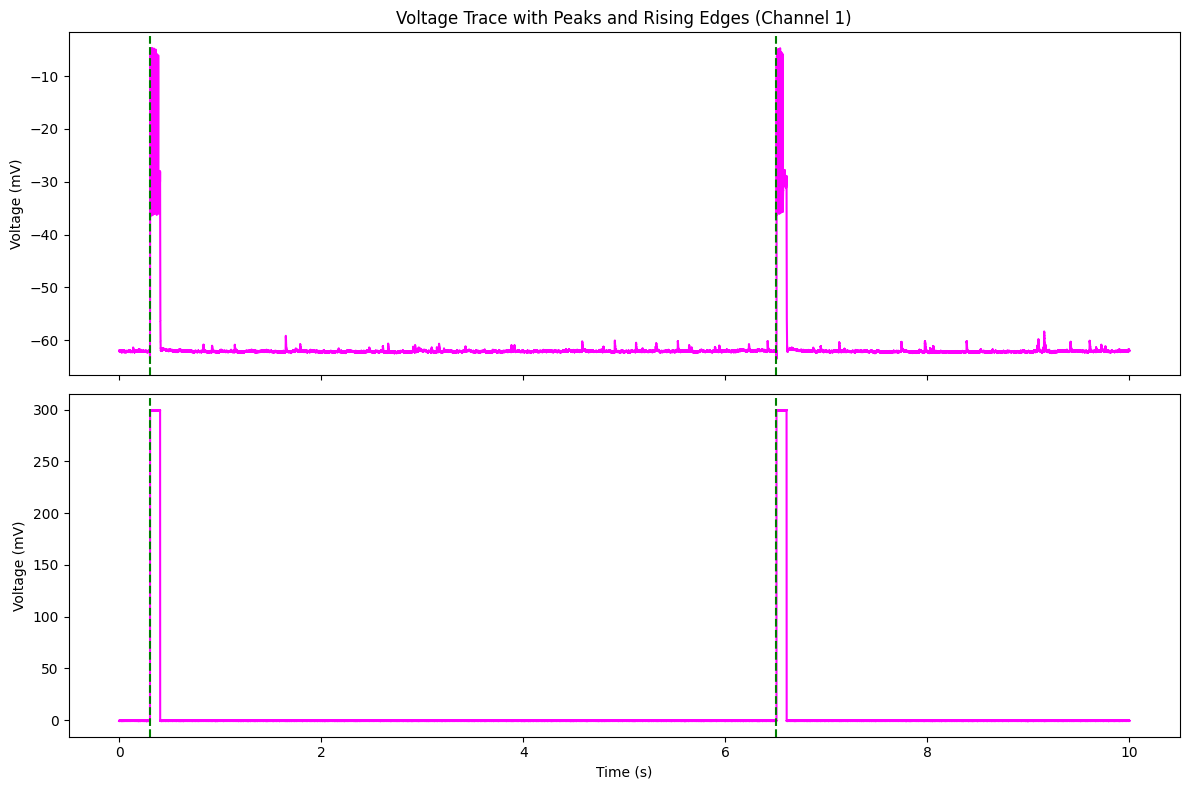

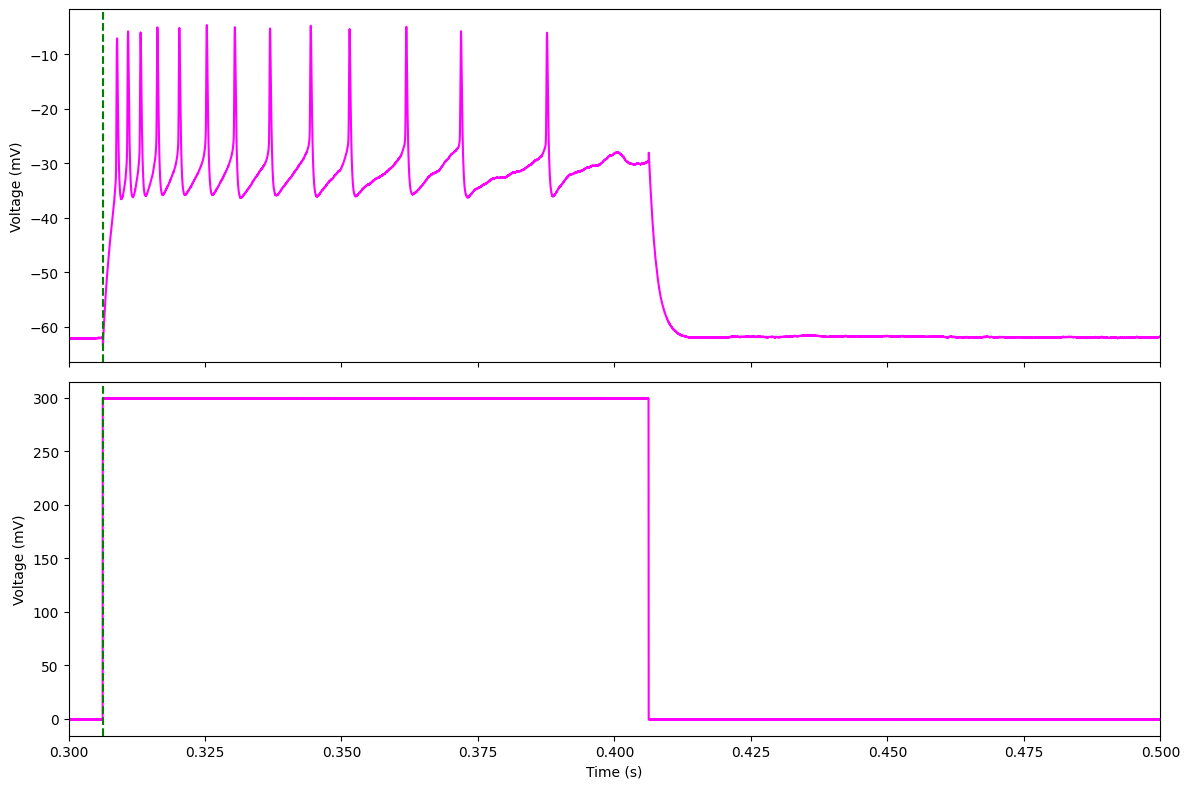

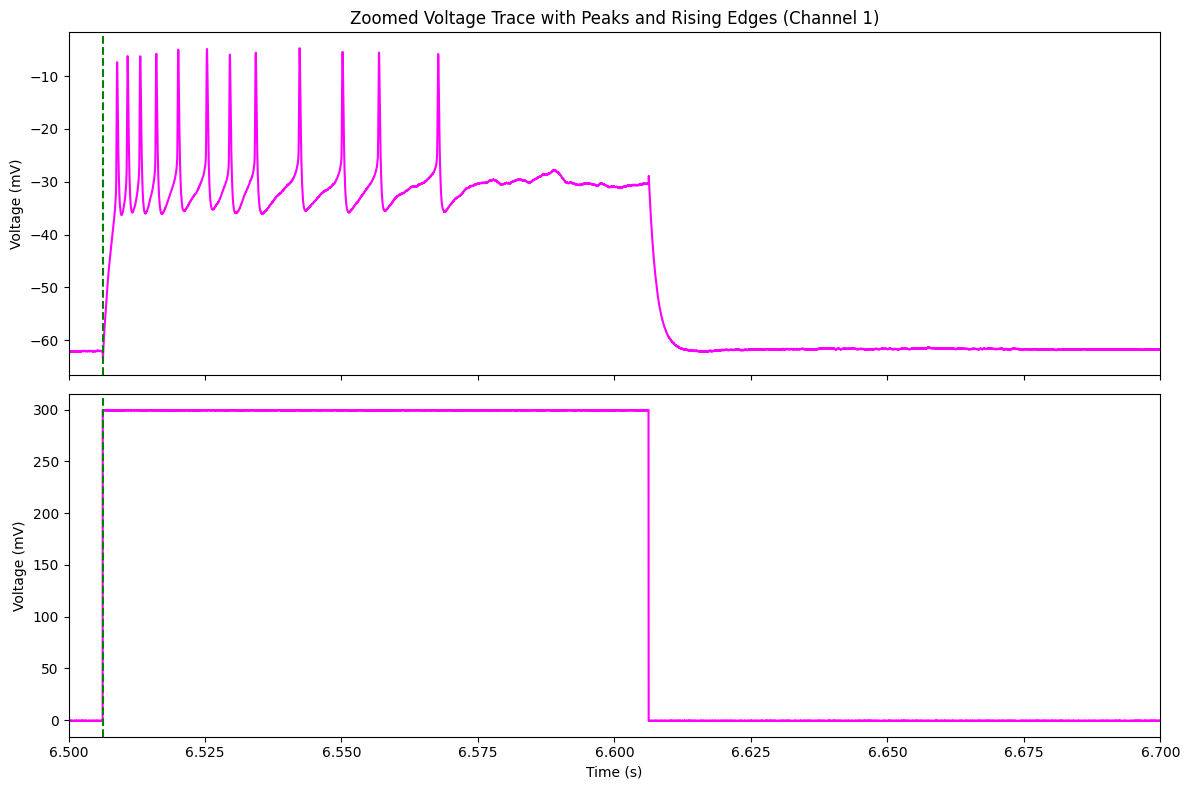

In [1]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the ABF file
file_path = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\no_light\24530012.abf'  # Replace with your file path
abf = pyabf.ABF(file_path)

# Select Channel 2 (index 1 since Python is 0-indexed) for square pulses
channel_index_pulse = 1
abf.setSweep(sweepNumber=0, channel=channel_index_pulse)

# Extract the time and voltage data for Channel 2
time_pulse = abf.sweepX  # Time in seconds
voltage_pulse = abf.sweepY  # Voltage in mV

# Identify the start of the square pulses (rising edges)
rising_edges_indices = np.where(np.diff(voltage_pulse) > 10)[0]  # Adjust threshold if necessary
rising_edges_times = time_pulse[rising_edges_indices]

print(f"Rising edges detected at {rising_edges_times} seconds.")

# Switch to the channel where the action potentials (bursts) are present, usually Channel 1 (index 0)
channel_index_burst = 0
abf.setSweep(sweepNumber=0, channel=channel_index_burst)

# Extract the time and voltage data for the action potential channel
time_burst = abf.sweepX  # Time in seconds
voltage_burst = abf.sweepY  # Voltage in mV

# Create a figure with two subplots: one for each channel
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot for Channel 1 (bursts)
axs[0].plot(time_burst, voltage_burst, label='Voltage Trace (Channel 1)', color='magenta')
for rising_edge_time in rising_edges_times:
    axs[0].axvline(x=rising_edge_time, color='g', linestyle='--')
axs[0].set_title('Voltage Trace with Peaks and Rising Edges (Channel 1)')
axs[0].set_ylabel('Voltage (mV)')

# Plot for Channel 2 (square pulses)
axs[1].plot(time_pulse, voltage_pulse, label='Voltage Trace (Channel 2)', color='magenta')
for rising_edge_time in rising_edges_times:
    axs[1].axvline(x=rising_edge_time, color='g', linestyle='--')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')

# Adjust layout, save, and display the plot
plt.tight_layout()
plt.savefig(r'C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\light\traces_full.svg')
plt.savefig(r'C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\light\traces_full.pdf')
plt.show()

# Zoomed-in plots for specific time windows
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot for Channel 1 (bursts)
axs[0].plot(time_burst, voltage_burst, label='Voltage Trace (Channel 1)', color='magenta')
for rising_edge_time in rising_edges_times:
    axs[0].axvline(x=rising_edge_time, color='g', linestyle='--')
axs[0].set_xlim(0.3, 0.5)
axs[0].set_ylabel('Voltage (mV)')

# Plot for Channel 2 (square pulses)
axs[1].plot(time_pulse, voltage_pulse, label='Voltage Trace (Channel 2)', color='magenta')
for rising_edge_time in rising_edges_times:
    axs[1].axvline(x=rising_edge_time, color='g', linestyle='--')
axs[1].set_xlim(0.3, 0.5)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')

plt.tight_layout()
plt.savefig(r'C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\light\traces_zoomed_0.3_0.5.svg')
plt.savefig(r'C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\light\traces_zoomed_0.3_0.5.pdf')
plt.show()

# Plot for different zoom level
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_burst, voltage_burst, label='Voltage Trace (Channel 1)', color='magenta')
for rising_edge_time in rising_edges_times:
    axs[0].axvline(x=rising_edge_time, color='g', linestyle='--')
axs[0].set_xlim(6.5, 6.7)
axs[0].set_title('Zoomed Voltage Trace with Peaks and Rising Edges (Channel 1)')
axs[0].set_ylabel('Voltage (mV)')

# Plot for Channel 2 (square pulses) - different zoom level
axs[1].plot(time_pulse, voltage_pulse, label='Voltage Trace (Channel 2)', color='magenta')
for rising_edge_time in rising_edges_times:
    axs[1].axvline(x=rising_edge_time, color='g', linestyle='--')
axs[1].set_xlim(6.5, 6.7)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')

plt.tight_layout()
plt.savefig(r'C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\light\traces_zoomed_6.5_6.7.svg')
plt.savefig(r'C:\Maha\DATA\patch_clamp\Kevin\excitability\300524_F1_C1\light\traces_zoomed_6.5_6.7.pdf')
plt.show()

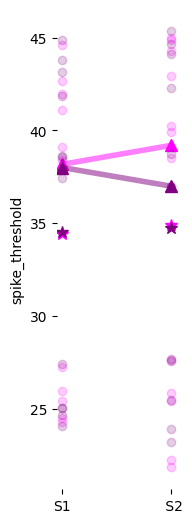

Plots have been generated and saved.



--- Comparison Results for spike_threshold ---
Wilcoxon Test (Pre Light vs. Pre No Light) - Stat: 36.0, p-value: 0.85009765625
Wilcoxon Test (Post Light vs. Post No Light) - Stat: 38.0, p-value: 0.9697265625
Wilcoxon Test (Pre vs. Post Light) - Stat: 30.0, p-value: 0.5185546875
Wilcoxon Test (Pre vs. Post No Light) - Stat: 37.0, p-value: 0.90966796875
         Parameter                    Comparison  Statistic   p-value
0  spike_threshold    Pre Light vs. Pre No Light       36.0  0.850098
1  spike_threshold  Post Light vs. Post No Light       38.0  0.969727
2  spike_threshold            Pre vs. Post Light       30.0  0.518555
3  spike_threshold         Pre vs. Post No Light       37.0  0.909668
Comparison results saved to C:\Maha\DATA\patch_clamp\Kevin\excitability\combined_stats_plots\comparison_results.csv


In [4]:
pip install scipy
from scipy.stats import wilcoxon, mannwhitneyu

# Perform Wilcoxon signed-rank test (only if sample sizes match)
if len(pre_light) > 0 and len(pre_no_light) > 0:
    if len(pre_light) == len(pre_no_light):
        stat, p_value = wilcoxon(pre_light, pre_no_light)
        test_name = "Wilcoxon Test (Paired)"
    else:
        stat, p_value = mannwhitneyu(pre_light, pre_no_light, alternative='two-sided')
        test_name = "Mann-Whitney U Test (Unpaired)"
    
    print(f"{test_name} - Stat: {stat}, p-value: {p_value}")


Mann-Whitney U Test (Unpaired) - Stat: 78.0, p-value: 1.0


New_figures


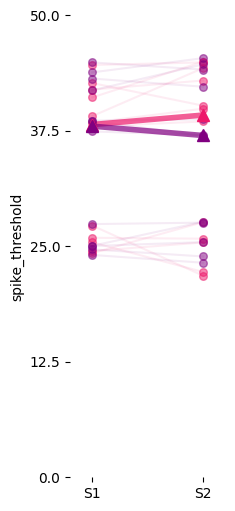

Plots have been generated and saved.


In [8]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

# Load the combined CSV file
csv_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\spike_threshold.csv'
df = pd.read_csv(csv_file_path)

# Ensure Step is labeled S1/S2
df["Step"] = df["Step"].map({1: "S1", 2: "S2"})

# Parameters to plot
parameters = ['spike_threshold']  # add more if needed

# Colors for conditions
color_mapping = {
    'light': '#ed186a',   # hex code requested
    'no_light': 'purple'
}

def nice_ceiling(x: float) -> float:
    """
    Round x up to a 'nice' number from {1, 2, 2.5, 5, 10} * 10^k.
    If x <= 0 or NaN, return 1.
    """
    if pd.isna(x) or x <= 0:
        return 1.0
    exp = math.floor(math.log10(x))
    frac = x / (10 ** exp)
    for n in (1, 2, 2.5, 5, 10):
        if frac <= n:
            return n * (10 ** exp)
    return 10 ** (exp + 1)

for parameter in parameters:
    fig, ax = plt.subplots(figsize=(2, 6))

    for condition, color in color_mapping.items():
        # Pair S1 and S2 within each File for this condition
        subset = (
            df[df['Condition'] == condition]
            .pivot_table(index="File", columns="Step", values=parameter, aggfunc="mean")
            .reindex(columns=["S1", "S2"])
            .dropna(subset=["S1", "S2"])
        )

        # Plot one faint line per File + solid markers
        for _, row in subset.iterrows():
            ax.plot([0.5, 1.0], [row["S1"], row["S2"]],
                    linewidth=1.5, color=color, alpha=0.08, zorder=1)
            ax.scatter([0.5, 1.0], [row["S1"], row["S2"]],
                       color=color, alpha=0.5, s=30, zorder=2)

        # Group median (triangles + bold line)
        ax.plot([0.5, 1.0],
                [subset["S1"].median(), subset["S2"].median()],
                marker='^', markersize=9, linestyle='None',
                color=color, label=f"{condition} median", zorder=3)
        ax.plot([0.5, 1.0],
                [subset["S1"].median(), subset["S2"].median()],
                linewidth=4, alpha=0.7, color=color, zorder=2)

    # Cosmetics
    ax.set_xticks([0.5, 1.0])
    ax.set_xticklabels(['S1', 'S2'])
    ax.set_ylabel(parameter)
    ax.margins(x=0.2)

    # ---- Consistent y-axis ticks: exactly 7 labels ----
    y_max_data = pd.to_numeric(df[parameter], errors='coerce').max()
    y_upper = nice_ceiling(float(y_max_data) if pd.notna(y_max_data) else 1.0)

    ax.set_ylim(0, y_upper)
    ax.yaxis.set_major_locator(LinearLocator(5))  # exactly 7 ticks
    # -----------------------------------------------

    # Minimal frame
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    # Save
    out_dir = os.path.dirname(csv_file_path)
    svg_path = os.path.join(out_dir, f'{parameter}_prepost_plot_1.svg')
    pdf_path = os.path.join(out_dir, f'{parameter}_prepost_plot_1.pdf')
    fig.savefig(svg_path)
    fig.savefig(pdf_path)

    plt.show()

print("Plots have been generated and saved.")



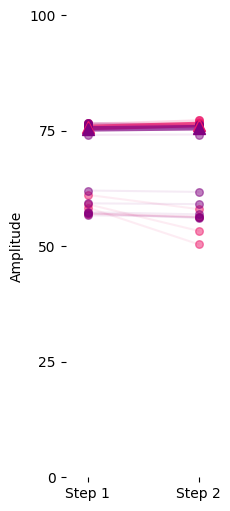

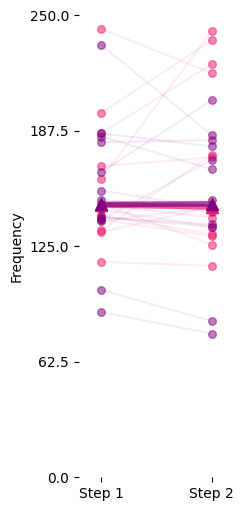

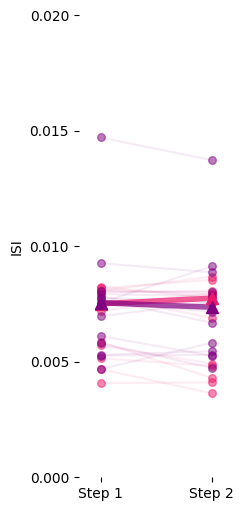

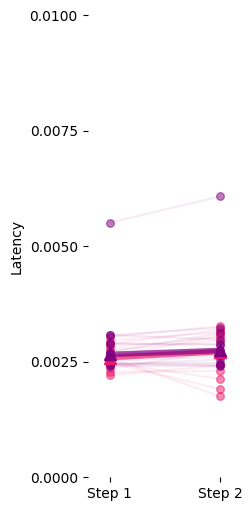

Plots have been generated and saved.


In [7]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

# Load the combined CSV file
csv_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\excitability\combined_stats_plots\excitability_combined.csv'
df = pd.read_csv(csv_file_path)

# Parameters to plot
parameters = ['Amplitude', 'Frequency', 'ISI', 'Latency']

# Colors for the conditions
color_mapping = {
    'light': '#ed186a',   # requested hex
    'no_light': 'purple'
}

def nice_ceiling(x: float) -> float:
    """
    Round x up to a 'nice' number from the set {1, 2, 2.5, 5, 10} * 10^k.
    If x <= 0 or NaN, return 1.
    """
    if pd.isna(x) or x <= 0:
        return 1.0
    exp = math.floor(math.log10(x))
    frac = x / (10 ** exp)
    for n in (1, 2, 2.5, 5, 10):
        if frac <= n:
            return n * (10 ** exp)
    # Fallback (shouldn't hit)
    return 10 ** (exp + 1)

for parameter in parameters:
    fig, ax = plt.subplots(figsize=(2, 6))

    for condition, color in color_mapping.items():
        cond_df = df[df['Condition'] == condition].copy()

        # Pair Step 1 and Step 2 within each File for this parameter
        paired = (
            cond_df.pivot_table(index='File', columns='Step', values=parameter, aggfunc='mean')
                   .reindex(columns=[1, 2])  # ensure order Step 1, Step 2
                   .dropna(subset=[1, 2])    # require both steps to draw a line
        )

        # Plot one faint line per File with solid markers on top
        for _, row in paired.iterrows():
            # faint connecting line
            ax.plot([0.5, 1.0], [row[1], row[2]],
                    linewidth=1.5, color=color, alpha=0.08, zorder=1)
            # solid markers
            ax.scatter([0.5, 1.0], [row[1], row[2]],
                       color=color, alpha=0.5, s=30, zorder=2)

        # Group median (triangles + bold line, solid)
        ax.plot([0.5, 1.0],
                [paired[1].median(), paired[2].median()],
                marker='^', markersize=9, linestyle='None',
                color=color, label=f"{condition} median", zorder=3)
        ax.plot([0.5, 1.0],
                [paired[1].median(), paired[2].median()],
                linewidth=4, alpha=0.7, color=color, zorder=2)

    # Cosmetics
    ax.set_xticks([0.5, 1.0])
    ax.set_xticklabels(['Step 1', 'Step 2'])
    ax.set_ylabel(parameter)
    ax.margins(x=0.2)

    # ---- Consistent y-axis ticks: exactly 7 labels, starting at 0 ----
    # Determine a nice upper limit for this parameter across all rows
    y_max_data = pd.to_numeric(df[parameter], errors='coerce').max()
    y_upper = nice_ceiling(float(y_max_data) if pd.notna(y_max_data) else 1.0)

    ax.set_ylim(0, y_upper)
    ax.yaxis.set_major_locator(LinearLocator(5))  # exactly 5 ticks from 0 to y_upper
    # ------------------------------------------------------------------

    # Minimal frame and no grid
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    # Save the plot as SVG and PDF
    out_dir = os.path.dirname(csv_file_path)
    svg_path = os.path.join(out_dir, f'{parameter}_prepost_plot_2.svg')
    pdf_path = os.path.join(out_dir, f'{parameter}_prepost_plot_2.pdf')
    fig.savefig(svg_path)
    fig.savefig(pdf_path)

    plt.show()

print("Plots have been generated and saved.")
